In [1]:
import networkx as nx
import matplotlib.pyplot as plt


# Defining a Class
class GraphVisualization:

    def __init__(self):

        # visual is a list which stores all
        # the set of edges that constitutes a
        # graph
        self.visual = []

    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()

In [2]:
import numpy as np
from scipy.special import expit as logsig
from scipy.stats import binom
import random
import matplotlib.pyplot as plt

def sampling_ising(A, N):
    """
    Sample from an Ising model with weight matrix A
    A is the weight matrix, A_ij = A_ji, assuming the mean-field = 0
    """
    s = A.shape[0]
    all_states = np.array([(np.array(list(bin(i)[2:].zfill(s)), dtype=int)*2-1) for i in range(2**s)])  #generates all states
    probs = np.array([np.exp(x @ A @ x.T / 2) for x in all_states])
    probs = probs / probs.sum()
    samples_idx = np.random.choice(2**s, size=N, p=probs)
    samples = all_states[samples_idx]           #maps index of chosen state to actual state
    return samples

def sampling_diamond(s, theta, rand_sign, num_sample):
    """
    Sampling from an Ising model with diamond graph structure
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    """
    A = np.zeros((s, s))
    A[0, 1:s-1] = theta
    A[s-1, 1:s-1] = theta
    A[1:s-1, 0] = theta
    A[1:s-1, s-1] = theta
    if rand_sign:
        sign_mat = np.triu((binom.rvs(1, 0.5, size=(s, s))*2-1), 1)
        A = A * (sign_mat + sign_mat.T)  # make it symmetric

    samples = sampling_ising(A, num_sample)
    return A, samples
def dDegreeGraphSampling(s, theta, rand_sign, num_sample,d):
    G = nx.random_regular_graph(d=d,n=s);
    A = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            if i!=j and G.has_edge(i,j):
                A[i][j] = theta*(-1 if rand_sign and random.random()<.5 else 1)
    return A,sampling_ising(A, num_sample)
def showMat(model):
    for i in range(len(model)):
        for j in range(len(model)):
            try:
                print("{0:.2f}".format(model[i][j]),end = " ")
            except:
                print(model[i][j],end=" ")
        print()

def mirror_descent(X, y, T, W1):
    """
    Use mirror descent to solve a logistic regression problem
    with simplex constraint:
    x_{t+1} = x_t exp(-eta*grad), x_{t+1} = x_{t+1} / ||x_{t+1}||_1
    """
    d = X.shape[1]
    N = X.shape[0]
    eta = np.sqrt(2 * np.log(d) / T) / (2 * W1)
    w = np.ones(d) / d
    w_sum = w.copy()

    for t in range(T):
        preds = logsig(X @ w) - y
        grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)  # could use stochastic gradient
        w = w * np.exp(-eta * grad)
        w = w / w.sum()
        w_sum = w_sum + w

    w_avg = w_sum / T
    # compute the gradient norm at w_avg
    preds = logsig(X @ w_avg) - y
    grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)
    g_norm = np.linalg.norm(grad)

    return w_avg, g_norm

def ising_learn(graph_size, num_sample, theta, rand_sign, num_iter):
    """
    graph_size: indicates the size of the graph; theta: weight of each edge
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    num_samples: number of samples; num_iter: number of mirror descent iterations
    """
    s = graph_size
    A, Xs = sampling_diamond(s, theta, rand_sign, num_sample)
    W1 = 2 * (s - 2) * theta
    A_hat = np.zeros((s, s))

    for i in range(s):
        y = (Xs[:, i] + 1) / 2
        X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        w, _ = mirror_descent(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2

    error = np.max(np.abs(A - A_hat))
    return error
def showModel(model):
    G = GraphVisualization()
    for i in range(len(model)):
        for j in range(i):
            if(model[i][j]!=0):
                G.addEdge(i,j);
    G.visualize()
def ising_learn_d_degree_graph(graph_size, num_sample, theta, rand_sign, num_iter,d,show = False):
    """
    graph_size: indicates the size of the graph; theta: weight of each edge
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    num_samples: number of samples; num_iter: number of mirror descent iterations
    """
    s = graph_size
    A, Xs = dDegreeGraphSampling(s, theta, rand_sign, num_sample,d)
    W1 = 2 * (s - 2) * theta
    A_hat = np.zeros((s, s))

    for i in range(s):
        y = (Xs[:, i] + 1) / 2
        X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        w, _ = mirror_descent(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
        topDedges = sorted([(A_hat[i,j],j) for j in range(s)])
        A_hat[i,:] = np.zeros(s)
        for k in range(d):
            A_hat[i,topDedges[-k-1][1]] = topDedges[-k-1][0]
    if show:
        print("Actual graph")
        showModel(A)
        showMat(A)
        print("predicted graph")
        showModel([[A_hat[i][j]!=0 for j in range(s)]for i in range(s)])
        showMat(A_hat)

    error = np.max(np.abs(A - A_hat))
    return error
def ising_learn_d_degree_graph_success(graph_size, num_sample, theta, rand_sign, num_iter,d,show = False):
    """
    graph_size: indicates the size of the graph; theta: weight of each edge
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    num_samples: number of samples; num_iter: number of mirror descent iterations
    """
    s = graph_size
    A, Xs = dDegreeGraphSampling(s, theta, rand_sign, num_sample,d)
    W1 = 2 * (s - 2) * theta
    A_hat = np.zeros((s, s))

    for i in range(s):
        y = (Xs[:, i] + 1) / 2
        X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        w, _ = mirror_descent(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
    topEdges = sorted([(abs(A_hat[i,j]),i,j) for j in range(s) for i in range(s)],reverse=True)
    out = np.zeros((s, s))
    degree = [0]*s;
    for weight,i,j in topEdges:
        if out[i][j]==0 and degree[i]<d and degree[j]<d:
            degree[i]+=1
            degree[j]+=1
            out[i][j] = A_hat[i,j]
            out[j][i] = out[i][j]
    if show:
        print("Actual graph")
        showModel(A)
        showMat(A)
        print("predicted graph")
        showModel(out)
        showMat(out)
    threshold = .01
    error = np.max(np.abs(A - A_hat))
    print("max error is ",error)
    for i in range(s):
        for j in range(s):
            if i!=j:
                t1 = 1 if A[i][j]>threshold else (-1 if A[i][j]<threshold else 0)
                t2 = 1 if out[i][j]>threshold else (-1 if out[i][j]<threshold else 0)
                if t1!=t2:
                    return A,out,0

    return A,out,1

In [3]:
# def ising_learn_d_degree_graph(graph_size, num_sample, theta, rand_sign, num_iter,d,show = False):
#     """
#     graph_size: indicates the size of the graph; theta: weight of each edge
#     if rand_sign = True, then the sign of each edge weight is random
#     if rand_sign = False, then all edge weights = theta
#     num_samples: number of samples; num_iter: number of mirror descent iterations
#     """
#     s = graph_size
#     A, Xs = dDegreeGraphSampling(s, theta, rand_sign, num_sample,d)
#     W1 = 2 * (s - 2) * theta
#     A_hat = np.zeros((s, s))

#     for i in range(s):
#         y = (Xs[:, i] + 1) / 2
#         X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
#         X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
#         w, _ = mirror_descent(X, y, num_iter, W1)
#         w = (w[:s-1] - w[s-1:2*s-2]) * W1
#         A_hat[i, :i] = w[:i] / 2
#         A_hat[i, i+1:] = w[i:] / 2
#         topDedges = sorted([(A_hat[i,j],j) for j in range(s)])
#         A_hat[i,:] = np.zeros(s)
#         for k in range(d):
#             A_hat[i,topDedges[-k-1][1]] = topDedges[-k-1][0]
#     if show:
#         print("Actual graph")
#         showModel(A)
#         showMat(A)
#         print("predicted graph")
#         showModel([[A_hat[i][j]!=0 for j in range(s)]for i in range(s)])
#         showMat(A_hat)

#     error = np.max(np.abs(A - A_hat))
#     return error

In [4]:
def getDivergence(A, B):
    s = A.shape[0]
    all_states = np.array([(np.array(list(bin(i)[2:].zfill(s)), dtype=int)*2-1) for i in range(2**s)])  #generates all states
    div=0;
    probsA = np.array([np.exp(x @ A @ x.T / 2) for x in all_states])
    probsA = probsA / probsA.sum()
    probsB = np.array([np.exp(x @ B @ x.T / 2) for x in all_states])
    probsB = probsB / probsB.sum()
    for i in range(2**s):
        div+=probsA[i]*np.log(probsA[i]/probsB[i]);
    return div

In [16]:
# Parameters
graph_size = 8
num_sample = 10000
theta = 0.1
rand_sign = True
num_iter = 1000

# Run the learning algorithm
error = ising_learn(graph_size, num_sample, theta, rand_sign, num_iter)
print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")

Maximum absolute error between true and estimated adjacency matrices: 0.0623


Actual graph


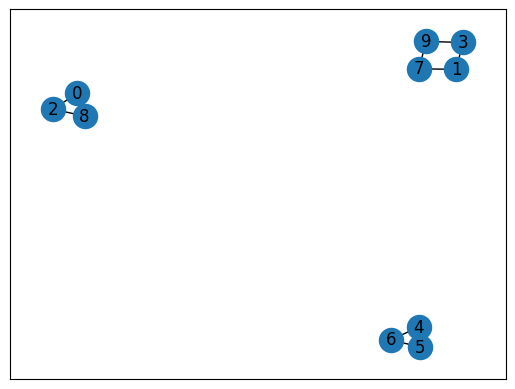

0.00 0.00 -0.10 0.00 0.00 0.00 0.00 0.00 0.10 0.00 
0.00 0.00 0.00 -0.10 0.00 0.00 0.00 -0.10 0.00 0.00 
-0.10 0.00 0.00 0.00 0.00 0.00 0.00 0.00 -0.10 0.00 
0.00 -0.10 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.10 
0.00 0.00 0.00 0.00 0.00 -0.10 -0.10 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -0.10 0.00 0.10 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -0.10 -0.10 0.00 0.00 0.00 0.00 
0.00 -0.10 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.10 
-0.10 0.00 -0.10 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.10 0.00 0.00 0.00 0.10 0.00 0.00 
predicted graph


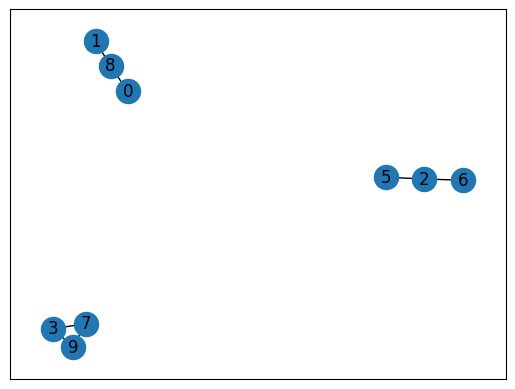

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.04 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.04 
0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.04 0.00 0.00 0.00 0.04 0.00 0.00 
Maximum absolute error between true and estimated adjacency matrices: 0.1051


In [18]:
graph_size = 10
num_sample = 10000
theta = 0.1
rand_sign = True
num_iter = 1000
d=2
# Run the learning algorithm
error = ising_learn_d_degree_graph(graph_size, num_sample, theta, rand_sign, num_iter,d,True)
print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")

In [20]:
import time
graph_size = 8
num_sample = 10000
theta = 0.1
rand_sign = True
num_iter = 5000
d=2
success = 0
start = time.perf_counter()
for i in range(1):
    inp,out,t = ising_learn_d_degree_graph_success(graph_size, num_sample, theta, rand_sign, num_iter,d)
    print("divergence is ",getDivergence(inp,out))
    success+= t
    # print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")
end = time.perf_counter()
print(f"number of successful predictions = \t {success}")
print(end-start)

max error is  0.11354699608294323
divergence is  0.0022139225879675693
number of successful predictions = 	 0
33.978292125000735
